In [1]:
from IPython.display import display, Image

# Open Distro for Elastic PoC

**Open Distro for Elasticsearch** is an Apache 2.0-licensed distribution of Elasticsearch enhanced with enterprise security, alerting, SQL, and more. These features were previously locked behind the paid distribution of Elasticsearch, but are now open source!

With it, it's possible to easily deploy both **Elasticsearch** (for data search and exploitation) and **Kibana** (for data analysis and reporting). We'll start with its setup, and then explore the good and the bad of each of its features.

## Setup

We'll focus on using **Docker** to setup nodes of **Elasticsearch** and a **Kibana** frontend. Luckily, there is a good `docker-compose` example on the official documentation [here](https://opendistro.github.io/for-elasticsearch-docs/docs/install/docker/#sample-docker-compose-file). Just download the `docker-compose.yml`, run `docker-compose up` and you are ready to go!

Kibana will now be up on `localhost:5601`, and you can login using *admin* as the user+password.

**NOTE**: When using `docker-compose`, if the nodes are failing to start you might need to increase the max virtual memory by running: `sudo sysctl -w vm.max_map_count=262144`

## Indexing data into Elasticsearch

**Elasticsearch** uses indexes to store its data, you can think about it as a database specialized for quickly searching text. 

We can interact with it using HTTP calls, for example `curl -XGET https://localhost:9200 -u admin:admin --insecure` would send a ping to the Elastic node just created and `curl -XPOST https://localhost:9200/test-index/doc -H "Content-Type: application/json" -d @test.json -u admin:admin --insecure
` would send the `test.json` document to an index called `test-index` (and create it if it didn't exist before!).

To use our data in **Elasticsearch** we'll need to *transform and index* our `.csv` data into the format required. Sadly, that format is `json` so we'll need to do some work!

Each row in our dataframe would be an **entry** to our index. We need to transform each row into a json. We can send multiple of these entries in bulk, which expects the following format:

```
Action and metadata\n
Optional document\n
Action and metadata\n
Optional document\n
```

And it would look something like this:

```json
{ "index": { "_index": "<index>", "_id": "<id>" } }
{ "key": "value1" }
{ "index": { "_index": "<index>", "_id": "<id>" } }
{ "key": "value2" }
```

Which is kind of ugly/annoying.

In [7]:
import json
import pandas as pd

output = open("revenue_bulk.json", "a")
df = pd.read_csv('../data/revenue.csv')
i = 0
with open("revenue_bulk.json", "a") as output:
    for index, row in df.iterrows():
        data = {}
        data['index'] = {"_index": "wildlife", "_id": index}
        output.write(f"{json.dumps(data)}\n")
        output.write(f"{row.to_json()}\n")
    output.write("\n")
    

#here is how it ends up looking
with open("revenue_bulk.json", "r") as output:
    for i in range(0,10):
        print(next(output))

{"index": {"_index": "wildlife", "_id": 0}}

{"date":"2020-05-17","provider":"ironsource","game":"android_battleroyale","row_count":1489,"requests":0.0,"impressions":35668,"clicks":7066.0,"revenue":39.069999693}

{"index": {"_index": "wildlife", "_id": 1}}

{"date":"2020-05-17","provider":"facebook","game":"android_flightpilot","row_count":2356,"requests":3572136.0,"impressions":32705,"clicks":882.0,"revenue":364.887697117}

{"index": {"_index": "wildlife", "_id": 2}}

{"date":"2020-05-17","provider":"facebook","game":"android_sniper3d","row_count":4125,"requests":169041883.0,"impressions":826614,"clicks":10676.0,"revenue":1898.7591762698}

{"index": {"_index": "wildlife", "_id": 3}}

{"date":"2020-05-17","provider":"tiktok","game":"battleroyale","row_count":6,"requests":0.0,"impressions":8346,"clicks":735.0,"revenue":81.7999992371}

{"index": {"_index": "wildlife", "_id": 4}}

{"date":"2020-05-17","provider":"inmobi","game":"ninjarunfree","row_count":42,"requests":3423.0,"impressions"

Then, we can fill our index with by sending the following bulk request:

`curl -XPOST https://localhost:9200/_bulk -H "Content-Type: application/x-ndjson" --data-binary @revenue_bulk.json -u admin:admin --insecure`

## A Look into Kibana

**Kibana** is a front end which allows us to interact with **Elastic**. From there, you can do the following:

- Consume and analyze logs and metrics from common sources (for example S3, Postgresql, nginx, Docker or even the system metrics). Most of them require a plugin to be installed before. OPINION: these seems like an easy solution for internal tech metrics, but won't be that useful for product analysis.
- Create Visualizations, queries and Dashboards from any index available. OPINION: here is where it gets interesting, the dashboard and metrics seem quite powerful.

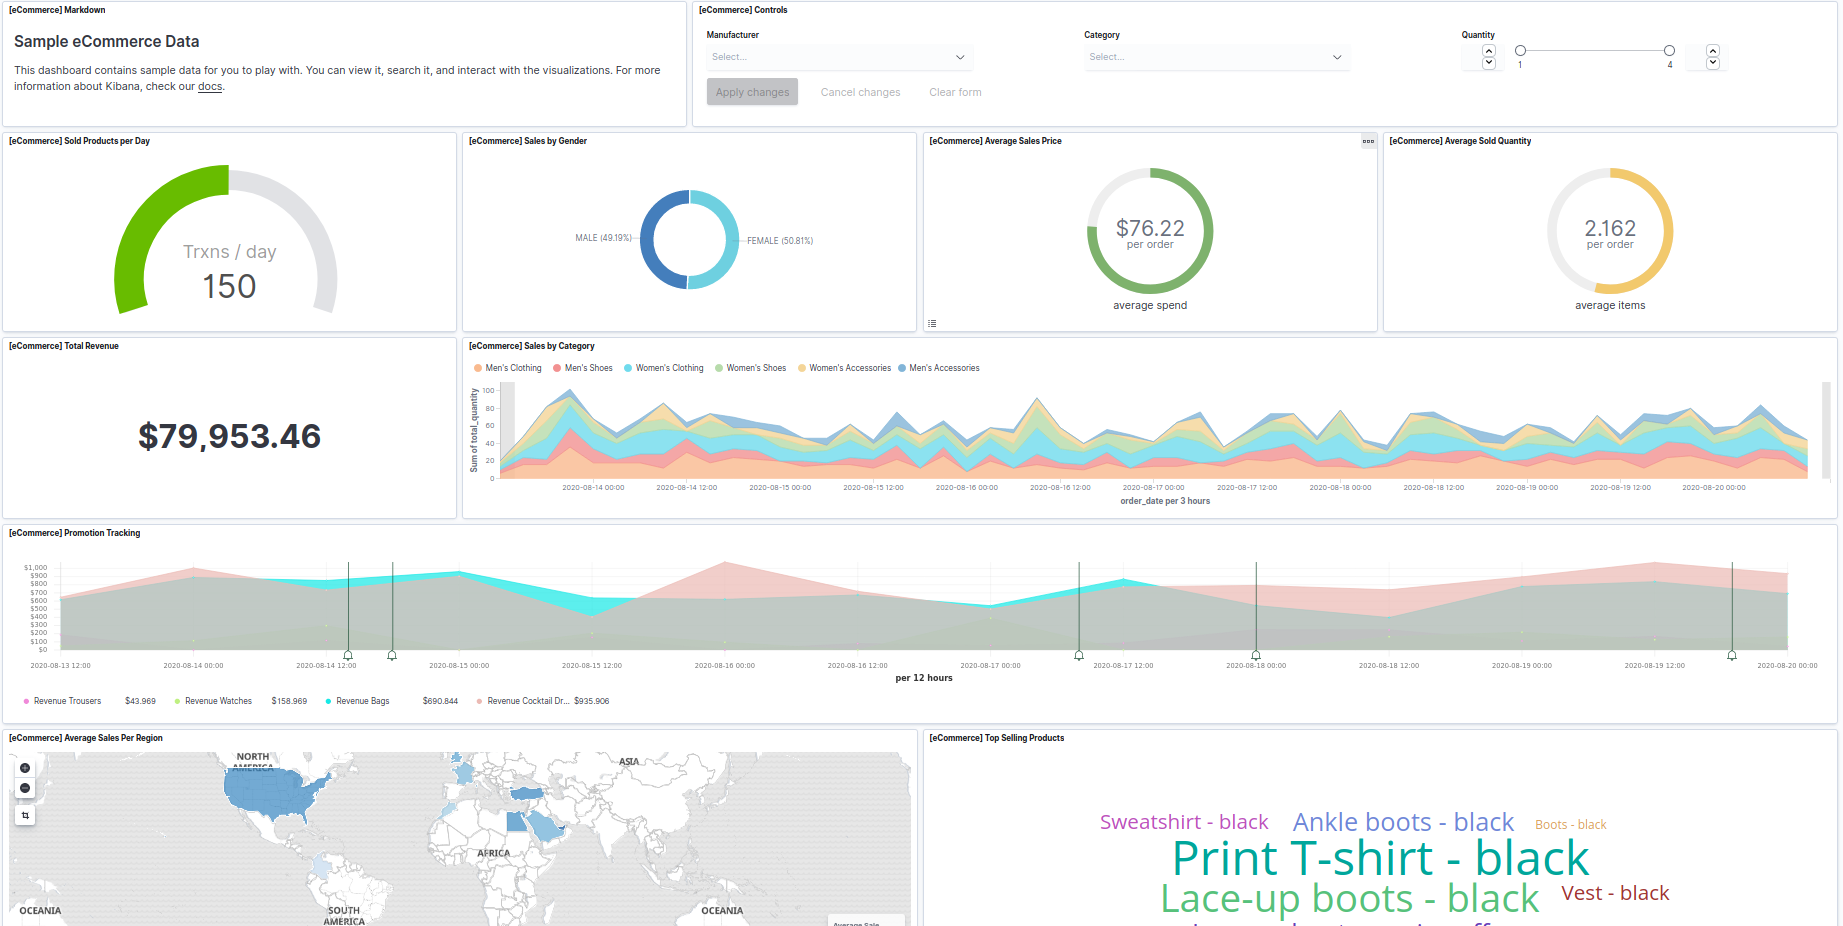

In [3]:
# quick look at what Elastic is capable of
display(Image(filename='dashboard-quicklook.png'))

With a few clicks I was able to plot a time series of revenue per Provider, and I was able to choose the time frequency (I could easily aggregate over 5 days or over a week if I wanted to), choose to only show the Top N providers and more. I bet it could be made prettier with a few more clicks!

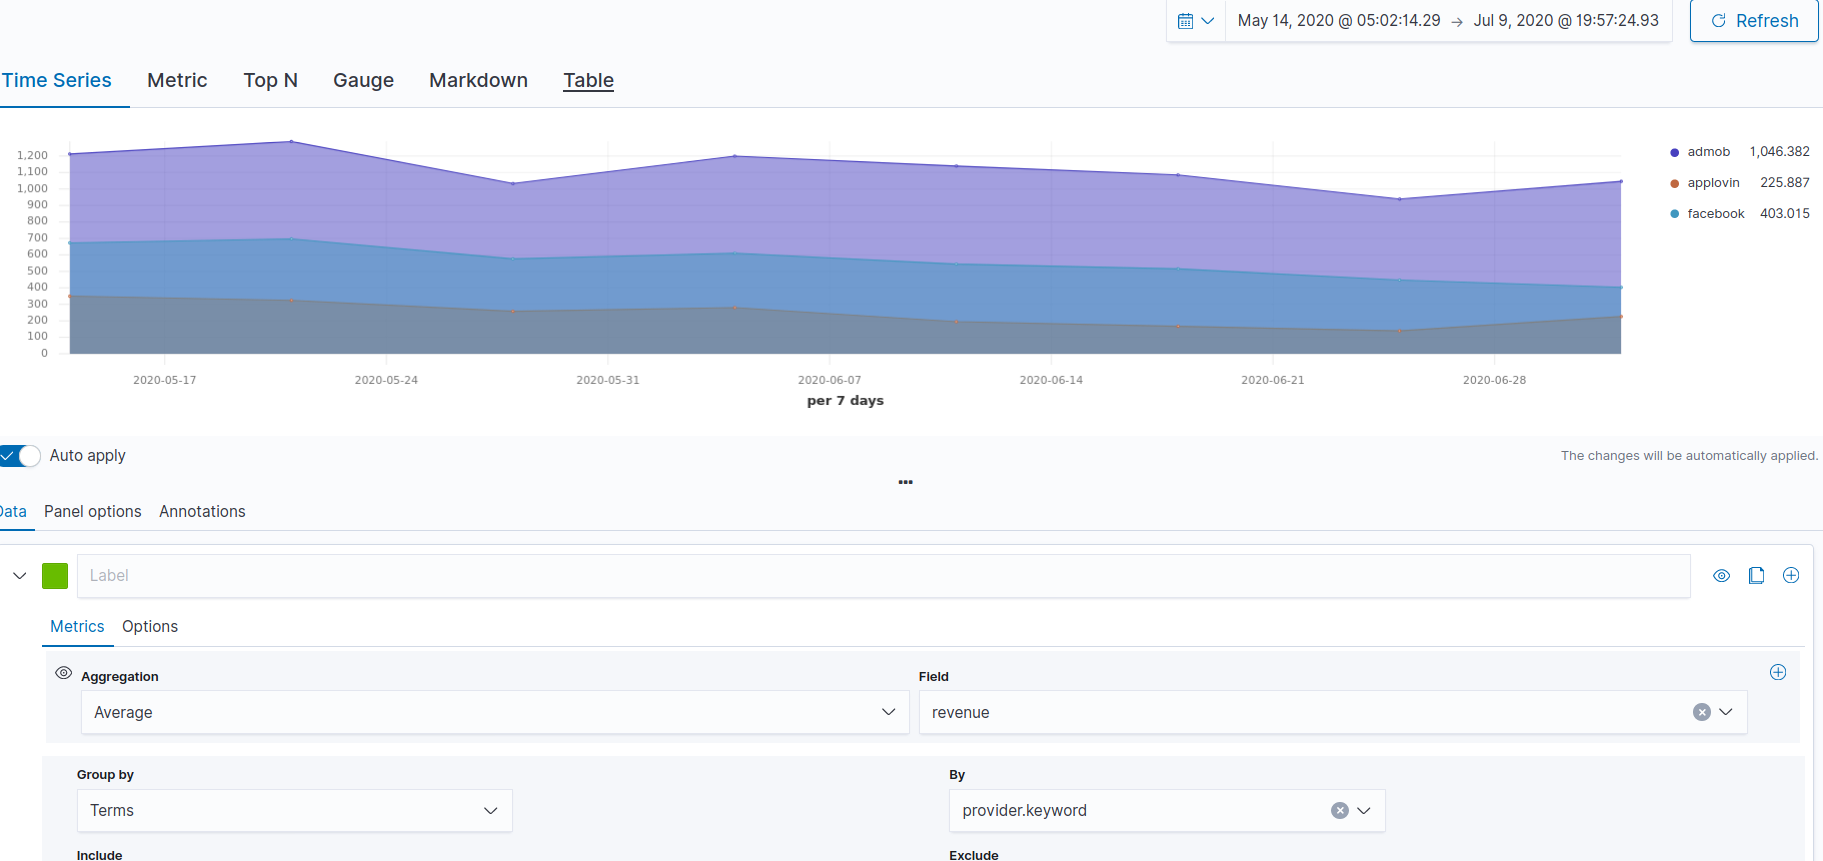

In [4]:
display(Image(filename='time_series.png'))

The plotting capabilities of Kibana are good, but it also gives a frontend for **Anomaly Detection**, **Alerting** and **Management** (dev tools).

## Anomaly Detection

Elastic uses the **Random Cut Forest** algorithm (now implemented on open source by aws in this [github](https://github.com/aws/random-cut-forest-by-aws)) for detecting anomalies, inspired by the **Isolation Forest** algorithm (already implemented in [scikit](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)), but with several changes made in order to make it perform better with streams of data, making it capable of **live detection of anomalies**.

Here come the bad news: it requires a lot of data points. And by a lot, I mean more than 400. Definitely **not good** for Time Series with a daily frequency. 

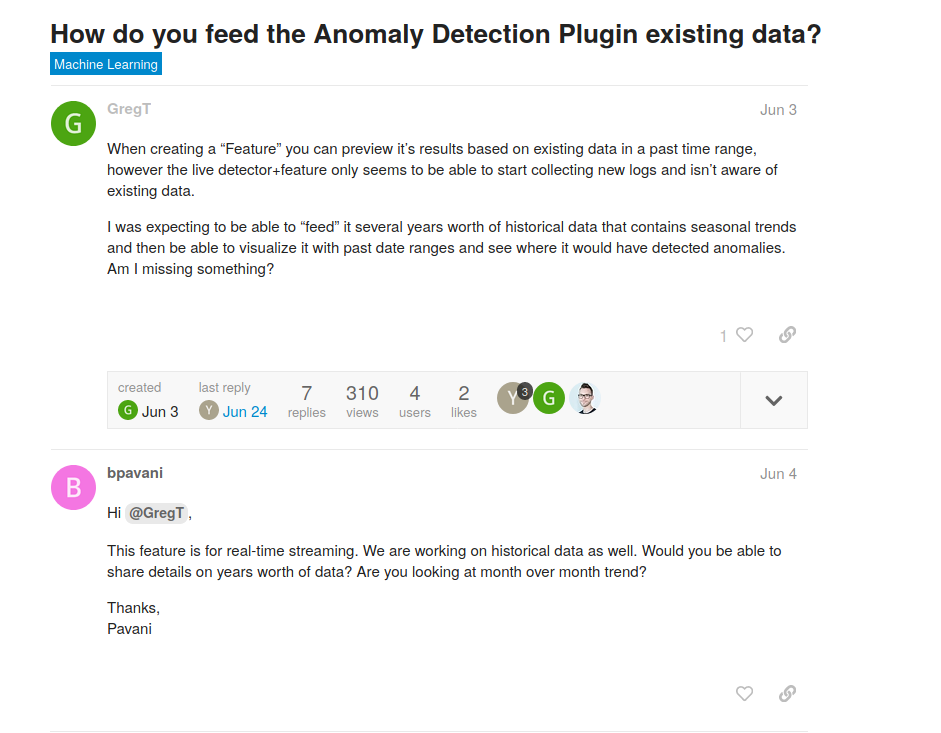

In [5]:
display(Image(filename='let_down.png'))

As they correctly mentioned, you can only **preview** anomalies over historical data, allowing you a limited toolset and visualizations to play around with your anomalies. Sad.

But what about the non fully Open Source alternative, Elastic? Does it have a better implementation? The answer is probably, but it's not part of their [Free Features](https://discuss.elastic.co/t/machine-learning-what-are-free-features/149566). 

## Some other features

Elastic still has some other cool features: such as **security** and **reporting**.

When it comes to security, Elasticsearch provides an already feature complete login system which uses Elastic as a database for user and roles. Also, it allows other auth services (such as LDAP or a custom HTTP call to a service). Roles can limit what a user can do inside Kibana (for example query certain indexes or stop them from creating monitor notifications).

Alerting is quite simple: just set an alarm on a certain threshold for a metric. For example if a metric has a value higher/lower than your threshold, it'll send an alarm. Same goes for anomalies, all anomalies are graded on their level of confidence/relevance, so you can set an alarm threshold on those values too.